# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl


In [19]:
def get_bins(values, n_bins=30): 
    return np.histogram(values, bins=n_bins)[1]

def draw_histogram(ax, values, n_bins=30, bins=None, vline='median', legend_label='', color='r', density=False):
    ax.hist(
        values,
        bins=bins if bins is not None else n_bins,
        histtype='step',
        label=legend_label,
        color=color,
        density=density
    )

    # add a vertical line.
    if vline == "median":
        ax.axvline(np.median(values), ls="--", color=color)


# Load data

In [6]:
from relaxed.analysis import setup, get_am

In [7]:
# catalog
hcat, indices, scales = setup('m11', path='../temp')
cvir = hcat.cat['cvir']

/home/imendoza/miniconda3/envs/alcca/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [8]:
# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../temp')

# throw away last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]
print(am.shape)

(9999, 98)


# Histogram of NaNs

## m11

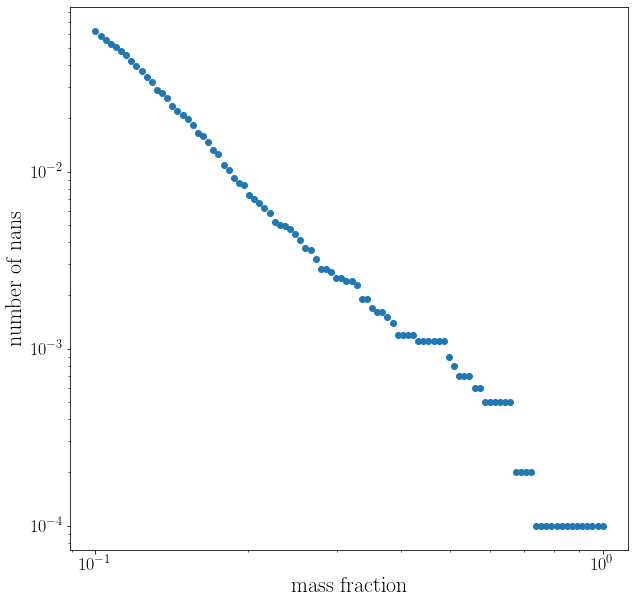

In [120]:
plt.figure(figsize=(10,10))
count_nans = np.array([ (sum(np.isnan(am[:, i]))+1)/(9999-sum(np.isnan(am[:,i]))) for i in range(len(mass_bins))])
plt.scatter(mass_bins, count_nans)
plt.xlabel('\\rm mass fraction', size=22)
plt.ylabel('\\rm number of nans', size=22)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.show()

## m12

In [65]:
hcat_12, indices, scales = setup('m12', path='../temp')
am_12, mass_bins_12 = get_am('m12', min_mass=0.1, path='../temp')

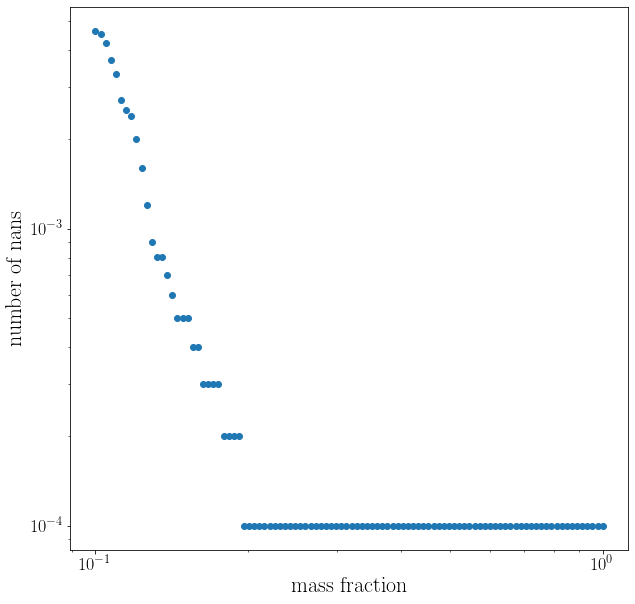

In [66]:
plt.figure(figsize=(10,10))
count_nans = np.array([ (sum(np.isnan(am_12[:, i]))+1)/(9999-sum(np.isnan(am_12[:,i]))) for i in range(len(mass_bins_12))])
plt.scatter(mass_bins_12, count_nans)
plt.xlabel('\\rm mass fraction', size=22)
plt.ylabel('\\rm number of nans', size=22)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.show()

# Test normality (with probplots)

## Example of normal distribution

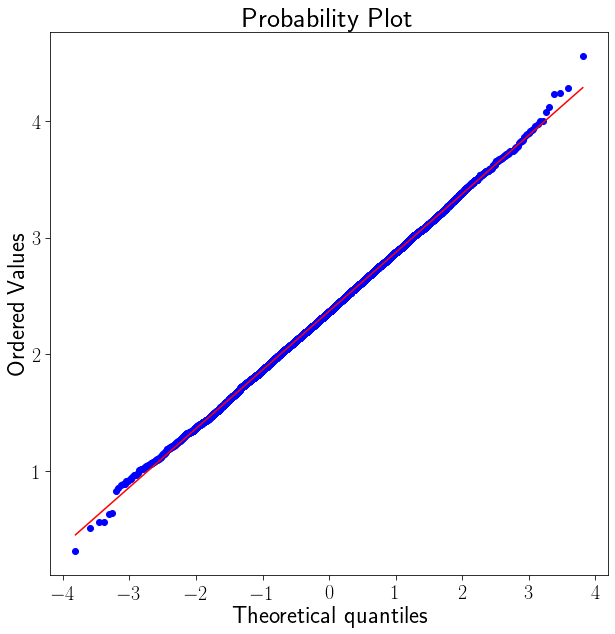

In [64]:
from scipy import stats

x = np.random.randn(10000)*np.std(np.log(cvir)) + np.mean(np.log(cvir))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
res = stats.probplot(x, dist='norm', plot=ax)



## log c_vir

In [14]:
# use a normaltest to check (H0 = is Gaussian, H1 = not Gaussian)
from scipy.stats import normaltest
k2, p = normaltest(np.log(cvir))
alpha = 1e-3
print(f'cannot reject null hypothesis' if alpha < p else 'reject null hypothesis')
print('p-value:', p)

reject null hypothesis
p-value: 2.2259140416470982e-130


Text(0.5, 1.0, 'Probability Plot for $\\log c_{\\rm vir}$')

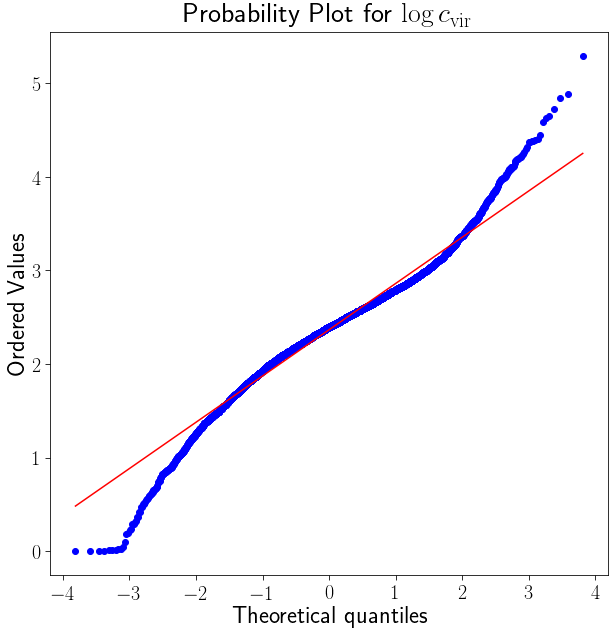

In [35]:
from scipy import stats

x = np.log(cvir)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
res = stats.probplot(x, dist='norm', plot=ax)
ax.set_title(r"Probability Plot for $\log c_{\rm vir}$")

# close enough!

## a_m_i

In [40]:
mass_bins[89]

0.8111308307896872

9999


Text(0.5, 1.0, 'Probability Plot for $a(m_i=0.81)$')

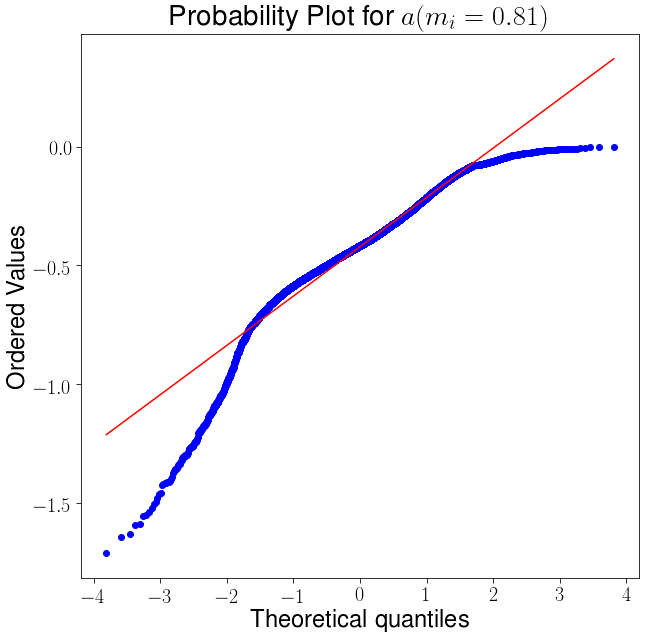

In [41]:
from scipy import stats
idx = 89
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.log(am[:, idx])
m= mass_bins[idx]
keep = ~np.isnan(x)
x = x[keep]
print(sum(keep))
res = stats.probplot(x, dist='norm', plot=ax, fit=True)
ax.set_title(f"Probability Plot for $a(m_i={m:.2f})$")


# becomes more non-Gaussian as m_i -> 0 or m_i -> 1 

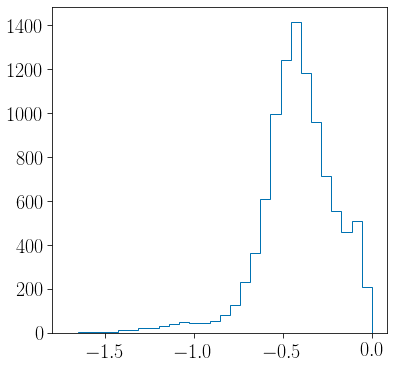

In [42]:
fig, ax = plt.subplots(1,1, figsize=(6, 6))
bins = get_bins(x)
draw_histogram(ax, x,bins=bins, vline=None, legend_label=r'$a(m_i={m:.2f})$', color=colors[0])




## Histograms

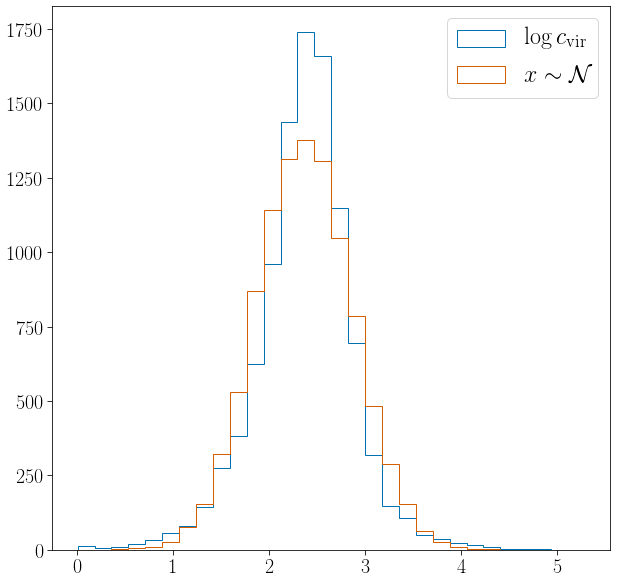

In [17]:
# looks Gaussian already
fig, ax = plt.subplots(1,1)
bins = get_bins(np.log(cvir))
draw_histogram(ax, np.log(cvir),bins=bins, vline=None, legend_label=r'$\log c_{\rm vir}$', color=colors[0])


# compare to gaussian
x = np.random.randn(9999)*np.std(np.log(cvir)) + np.mean(np.log(cvir))
draw_histogram(ax, x, bins=bins, vline=None, legend_label=r'$x \sim \mathcal{N}$', color=colors[2])


ax.tick_params(which='both', labelsize=20)
ax.legend()

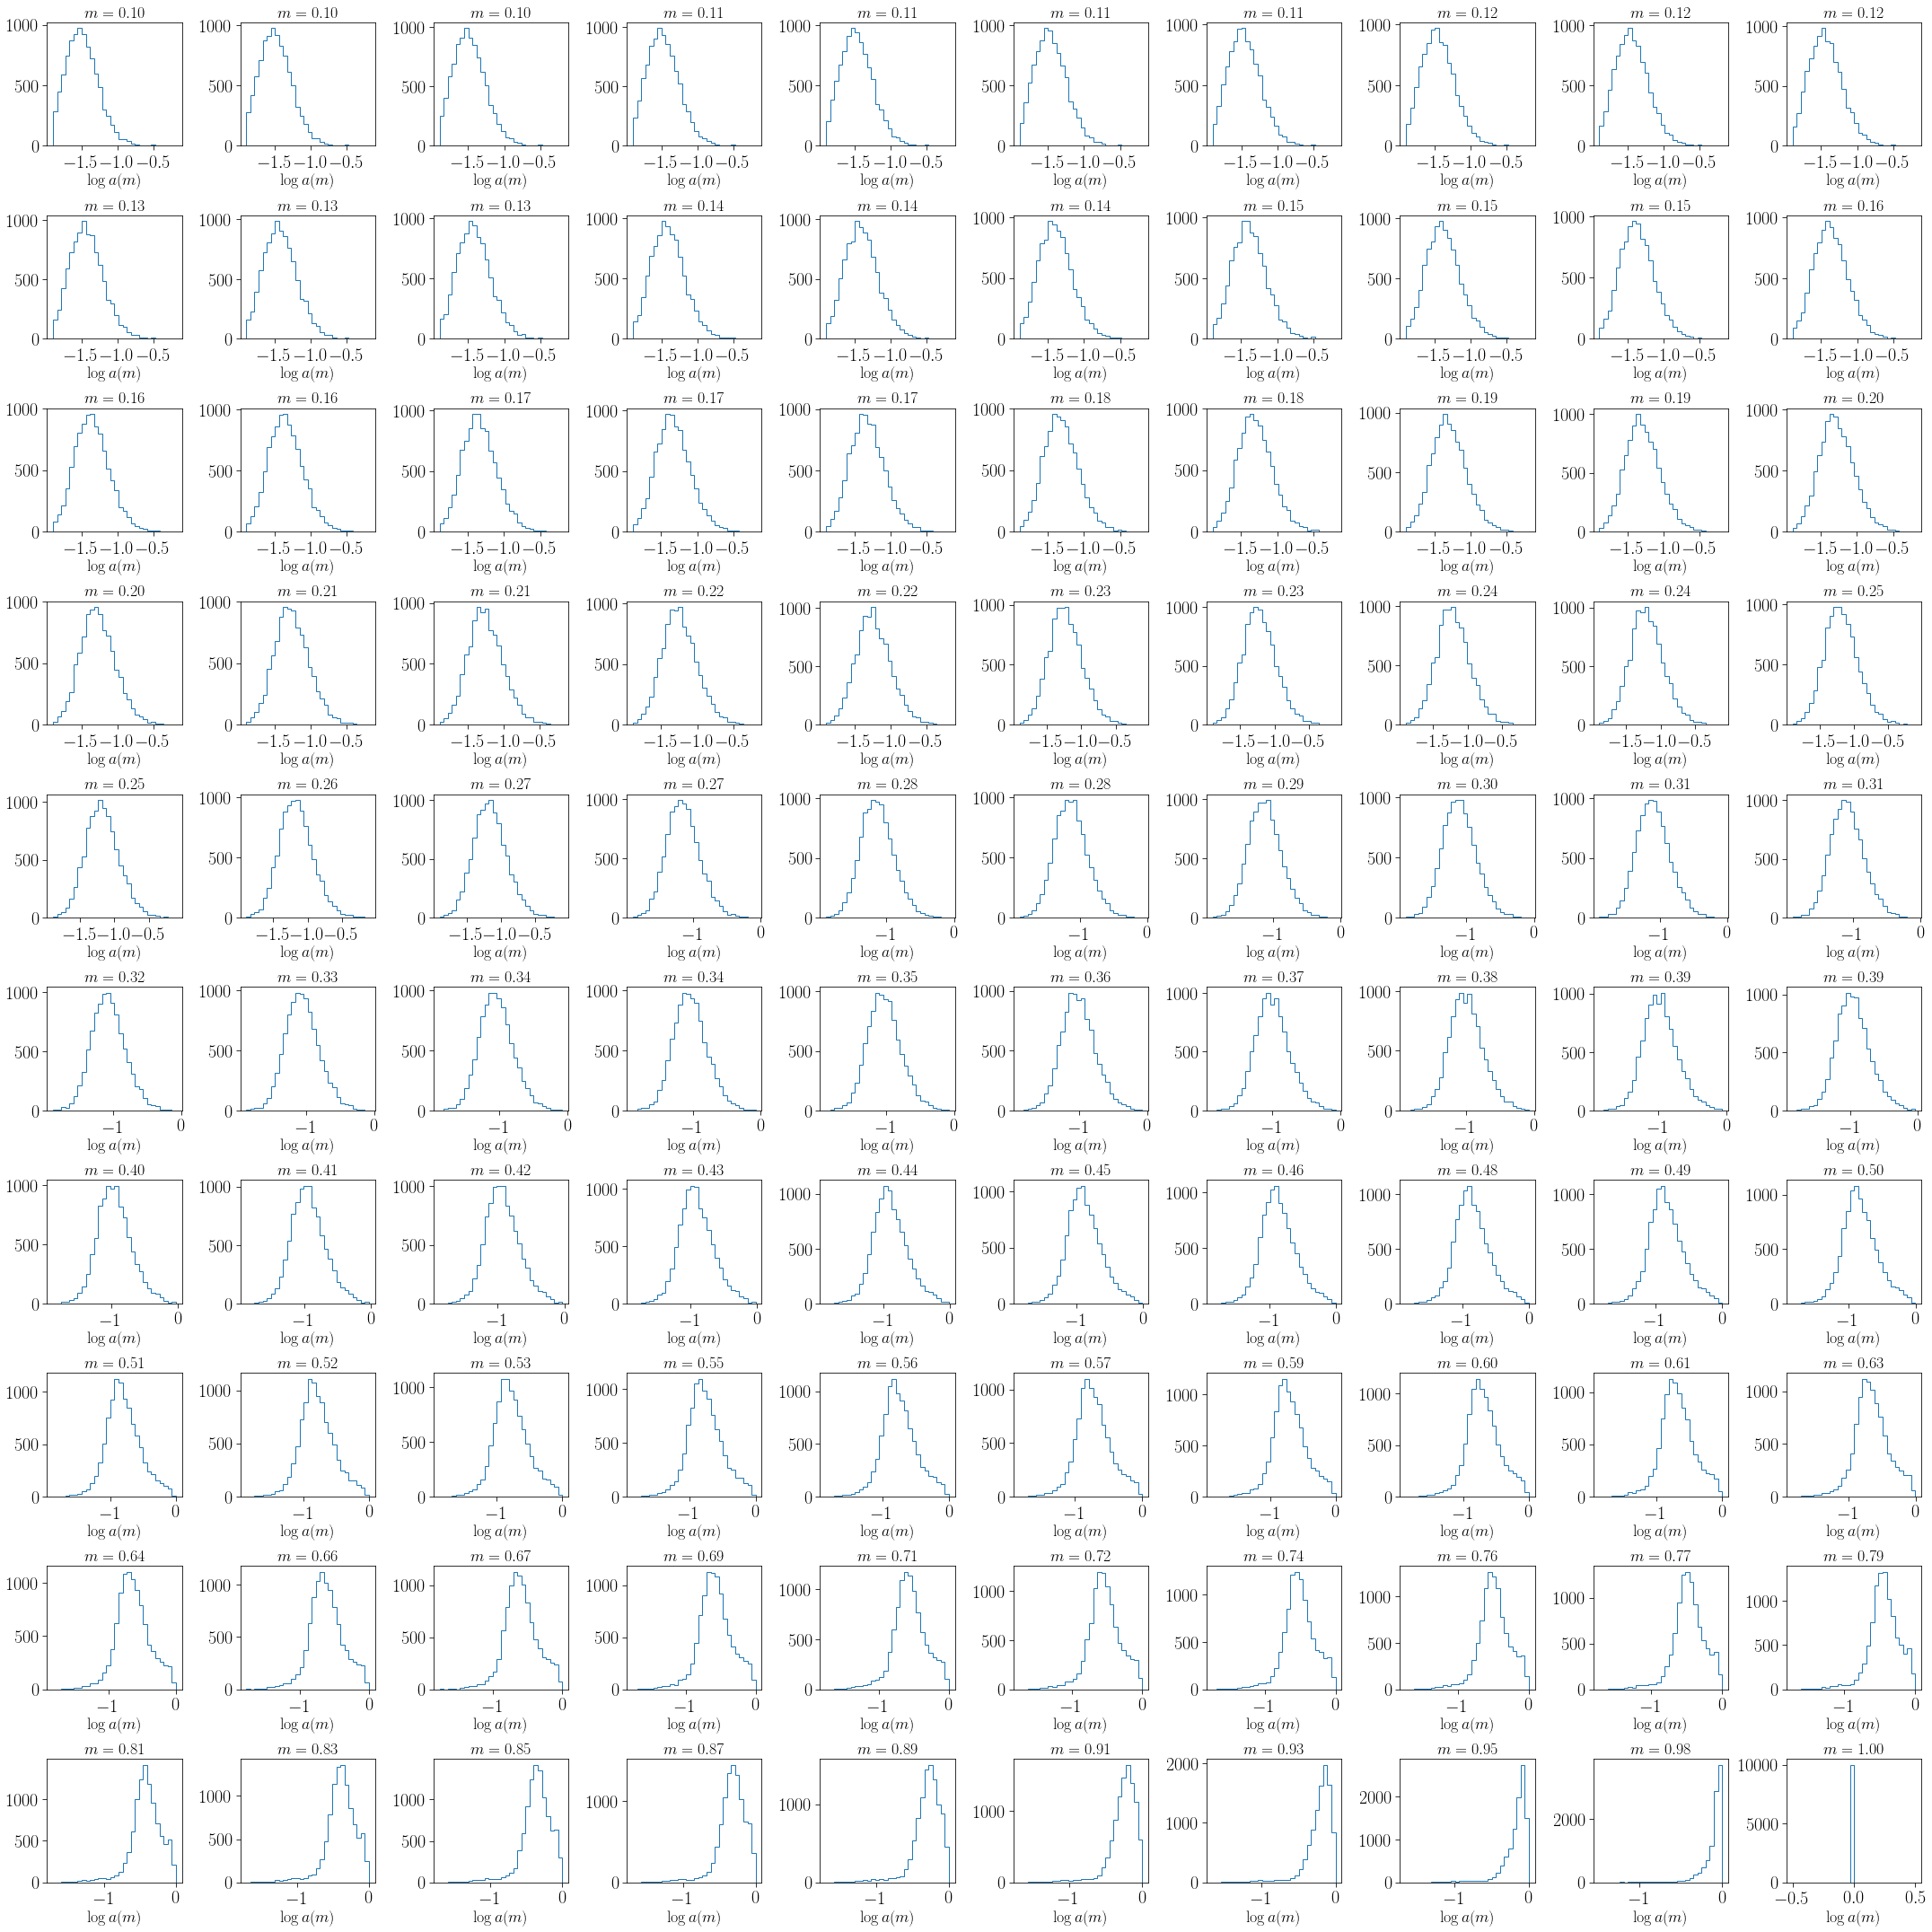

In [16]:
fig, axes = plt.subplots(10, 10, figsize=(30, 30))
axes = axes.flatten()

for i in range(100): 
    ax = axes[i]
    mass_bin = mass_bins[i]
    ax.hist(np.log(am[:, i]), histtype='step', bins=30)
    ax.set_title(f"$m={mass_bin:.2f}$", size=18)
    ax.set_xlabel("$\\log a(m)$", size=18)
plt.tight_layout()

# Correlations between a_m(i)

In [56]:
from scipy.stats import spearmanr
n_mbins = 100
corrs = np.zeros((n_mbins, n_mbins))
for i in range(n_mbins):
    for j in range(n_mbins):
        corrs[i,j] = spearmanr(am[:,i], am[:, j], nan_policy='omit')[0]

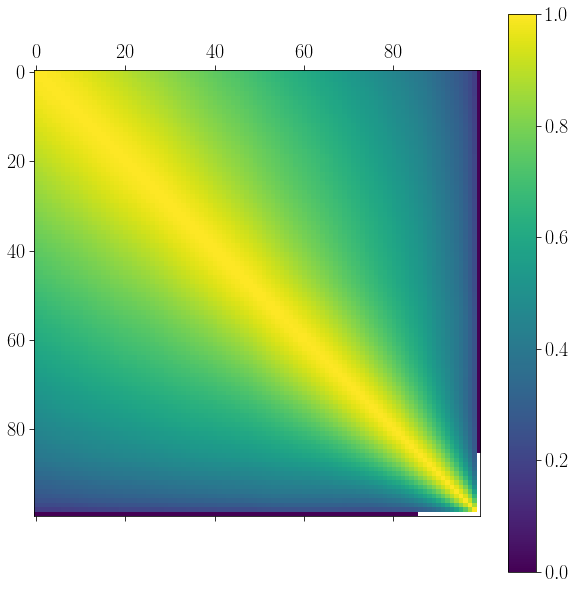

In [61]:
plt.matshow(corrs)
plt.colorbar()

In [122]:
mass_bins

array([0.1       , 0.1023531 , 0.10476158, 0.10722672, 0.10974988,
       0.1123324 , 0.1149757 , 0.1176812 , 0.12045035, 0.12328467,
       0.12618569, 0.12915497, 0.13219411, 0.13530478, 0.13848864,
       0.14174742, 0.14508288, 0.14849683, 0.15199111, 0.15556761,
       0.15922828, 0.16297508, 0.16681005, 0.17073526, 0.17475284,
       0.17886495, 0.18307383, 0.18738174, 0.19179103, 0.19630407,
       0.2009233 , 0.20565123, 0.21049041, 0.21544347, 0.22051307,
       0.22570197, 0.23101297, 0.23644894, 0.24201283, 0.24770764,
       0.25353645, 0.25950242, 0.26560878, 0.27185882, 0.27825594,
       0.28480359, 0.29150531, 0.29836472, 0.30538555, 0.31257158,
       0.31992671, 0.32745492, 0.33516027, 0.34304693, 0.35111917,
       0.35938137, 0.36783798, 0.37649358, 0.38535286, 0.39442061,
       0.40370173, 0.41320124, 0.42292429, 0.43287613, 0.44306215,
       0.45348785, 0.46415888, 0.47508102, 0.48626016, 0.49770236,
       0.5094138 , 0.52140083, 0.53366992, 0.54622772, 0.55908

# Algorithm

In [12]:
from scipy import stats
from scipy.stats import spearmanr

def get_quantiles(arr):
    return np.vectorize(lambda x: stats.percentileofscore(arr, x))(arr) / 100.

def gaussian_conditional(x, lam, ind=False):
    # x represents one of the dark matter halo properties at z=0. 
    # x and log(am) is assumed to be Gaussian.
    
    n_bins = lam.shape[1]
    assert len(x.shape)==1
    assert lam.shape == (x.shape[0], n_bins)
    
    # calculate sigma/correlation matrix bewteen all quantitie
    z = np.vstack([x.reshape(1,  -1), lam.T]).T
    assert z.shape == (x.shape[0], n_bins+1)
    np.testing.assert_equal(x, z[:, 0])
    np.testing.assert_equal(lam[:, 0], z[:, 1]) # ignore mutual nan's
    np.testing.assert_equal(lam[:, -1], z[:, -1])
    
    # calculate covariances
    Sigma = np.zeros((1 + n_bins, 1 + n_bins))
    rho = np.zeros((1 + n_bins, 1 + n_bins))
    for i in range(n_bins+1):
        for j in range(n_bins+1):
            if i <= j:
                z1, z2 = z[:, i], z[:, j]
                keep = ~np.isnan(z1) & ~np.isnan(z2)
                cov = np.cov(z1[keep], z2[keep])
                assert cov.shape == (2, 2)
                Sigma[i, j] = cov[0, 1]
                rho[i, j] = np.corrcoef(z1[keep], z2[keep])[0, 1]
            else: 
                rho[i, j] = rho[j, i]
                Sigma[i, j] = Sigma[j, i]

                
    # we assume a multivariate-gaussian distribution P(X, a(m1), a(m2), ...) with
    # conditional distribution P(X | {a(m_i)}) uses the rule here: 
    # https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution
    # we return the mean/std deviation of the conditional gaussian.
    assert np.all(~np.isnan(Sigma))
    assert np.all(~np.isnan(rho))
    
    mu1 = np.nanmean(z[:, 0]).reshape(1, 1)
    mu2 = np.nanmean(lam, axis=0).reshape(n_bins, 1)
    Sigma11 = Sigma[0, 0].reshape(1, 1)
    Sigma12 = Sigma[0, 1:].reshape(1, n_bins)
    Sigma22 = Sigma[1:, 1:].reshape(n_bins, n_bins)
    
    if ind: 
        for i in range(Sigma22.shape[0]):
            for j in range(Sigma22.shape[1]):
                if i!=j:
                    Sigma22[i, j]= 0
    
    def mu_cond(lam_test):
        assert np.sum(np.isnan(lam_test)) == 0
        lam_test = lam_test.reshape(-1, n_bins).T
        mu_cond = mu1 + Sigma12.dot(np.linalg.inv(Sigma22)).dot(lam_test-mu2)
        return mu_cond.reshape(-1)
    
    sigma_cond = Sigma11 - Sigma12.dot(np.linalg.inv(Sigma22)).dot(Sigma12.T)
    
    return mu1, mu2, Sigma, rho, mu_cond, sigma_cond

In [13]:
# separate into train/validation set. 
lam =  np.log(am)

# for testing set, pick from haloes that do not have NaNs in their a(m) history. 
# since the training ones it's a lot easier to handle the NaNs consistently and not throw away data points.
assert np.sum(np.isnan(np.log(cvir))) == 0
keep = np.ones(len(lam), dtype=bool)
for i in range(len(lam)):
    keep[i] = ~np.any(np.isnan(lam[i, :]))
test_indices = np.random.choice(np.where(keep)[0], size=9400, replace=False)
train_indices = test_indices

cvir_test = cvir[test_indices]
cvir_train = cvir[train_indices]

lam_test = lam[test_indices]
lam_train = lam[train_indices]


assert np.sum(np.isnan(lam_test)) == 0
assert np.sum(np.isnan(lam_train)) == 0
assert lam_test.shape == (9400, 98)
assert lam_train.shape == (9400, 98)

## Try producing some synthetic data to test algorithm

In [49]:
mean = np.array([1, 0])
cov = np.array([[1, 0.99], [0.99, 1]])
x, y = np.random.multivariate_normal(mean, cov, 5000).T
# we should easily be able to condition on x and get y very precisely with some small scatter (~around 0.5)

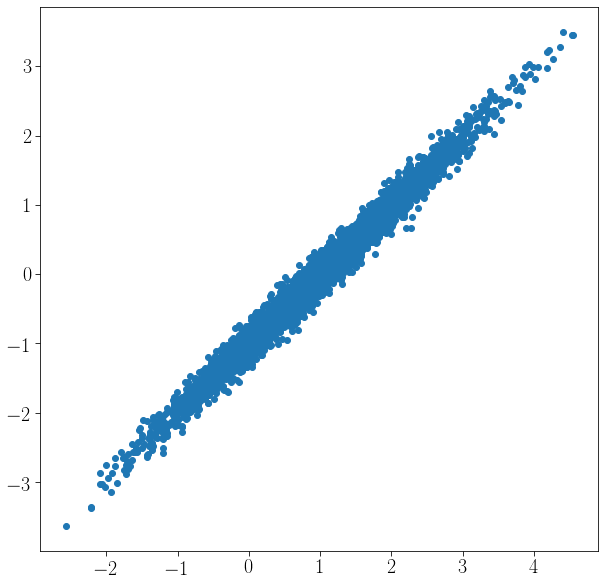

In [44]:
# display synthetic data
plt.scatter(x,y)

In [45]:
x_train = x[:4000]
x_test = x[4000:]

y = y.reshape(-1, 1)
y_train = y[:4000]
y_test = y[4000:]

print(x_test.shape, y_test.shape)

(1000,) (1000, 1)


In [46]:
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(x_train, y_train)

In [48]:
x_pred = mu_cond(y_test)

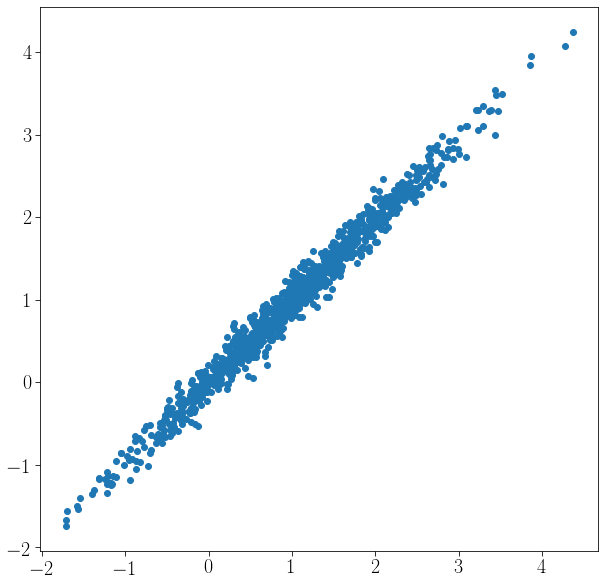

In [49]:
plt.scatter(x_test, x_pred)

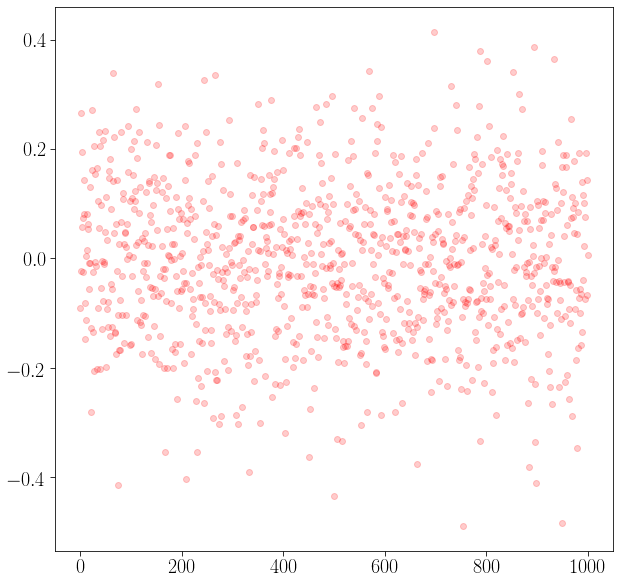

In [50]:
plt.plot(x_pred - x_test, 'ro', alpha=0.2)

## Test on real c_vir

In [14]:
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train)
assert callable(mu_cond)

### See correlation coefficients (from covariance matrix, not spearman)

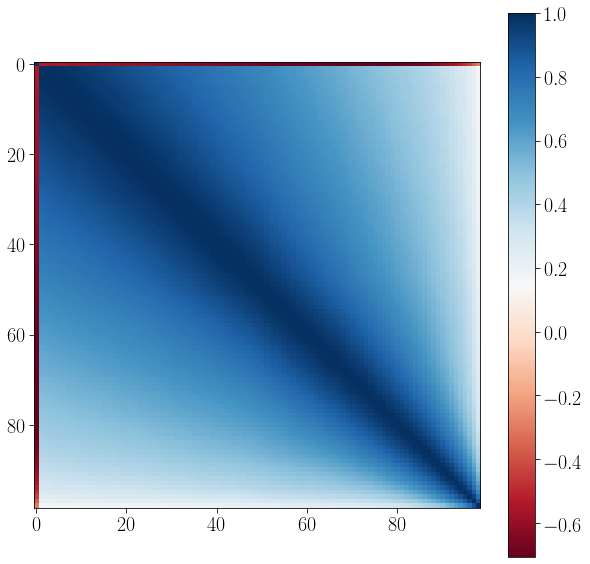

In [51]:
plt.imshow(rho, cmap='RdBu')
plt.colorbar()

### Test on held out data

In [15]:
log_cvir_pred = mu_cond(lam_test)
print(log_cvir_pred.shape)

(9400,)


Text(0, 0.5, '$\\rm counts$')

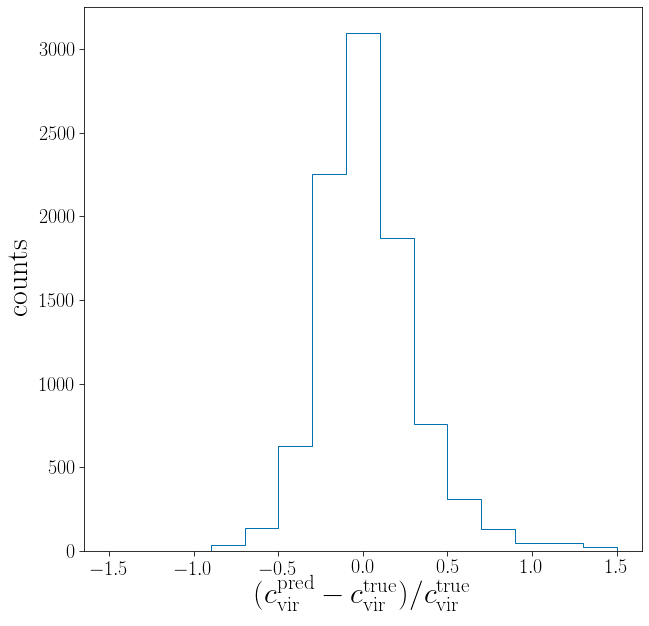

In [16]:
cvir_pred = np.exp(log_cvir_pred)

plt.hist( (cvir_pred - cvir_test) / cvir_test , histtype='step', bins=15, range=(-1.5, 1.5))
plt.xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
plt.ylabel(r"$\rm counts$", size=30)

In [54]:
import scipy
scipy.stats.spearmanr(cvir_pred, cvir_test)[0]

0.7668533130324293

### comparsion with baseline method.

Text(0.5, 1.0, '$c_{\\rm vir}^{\\rm pred} \\sim LN(\\mu^{\\rm true}, \\sigma^{\\rm true})$')

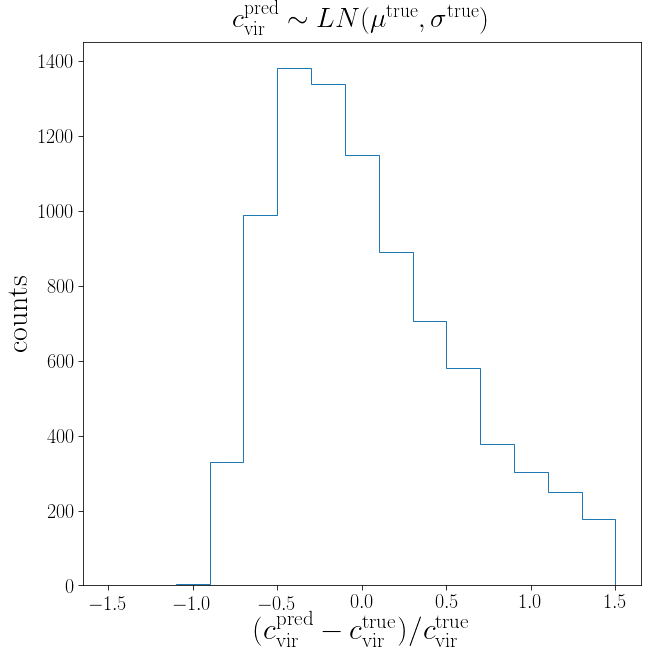

In [57]:
# sampling from lognormal with mean/var equal to true distribution.
log_cvir_pred = np.random.normal(np.mean(np.log(cvir)), np.std(np.log(cvir)), 9400)
cvir_pred = np.exp(log_cvir_pred)

plt.hist( (cvir_pred - cvir_test) / cvir_test , histtype='step', bins=15, range=(-1.5, 1.5))
plt.xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
plt.ylabel(r"$\rm counts$", size=30)
plt.title(r"$c_{\rm vir}^{\rm pred} \sim LN(\mu^{\rm true}, \sigma^{\rm true})$")


In [58]:
scipy.stats.spearmanr(cvir_pred, cvir_test)

SpearmanrResult(correlation=-0.00018366918184380072, pvalue=0.9857944001211332)

### Ranks using a1/2

In [74]:
idx = np.where((0.498 < mass_bins) & (mass_bins < 0.51) )[0].item()
a_2 = am[:, idx]

_train_indices = train_indices[:9000]
_test_indices = test_indices[9000:]
sort_train = np.argsort(a_2[_train_indices])
sort_test = np.argsort(a_2[_test_indices])

a_2_train = a_2[_train_indices][sort_train]
a_2_test = a_2[_test_indices][sort_test]

cvir_train = cvir[_train_indices][sort_train]
cvir_test = cvir[_test_indices][sort_test]

print(a_2.shape)
print(a_2_train.shape)
print(a_2_test.shape)

(9999,)
(9000,)
(400,)


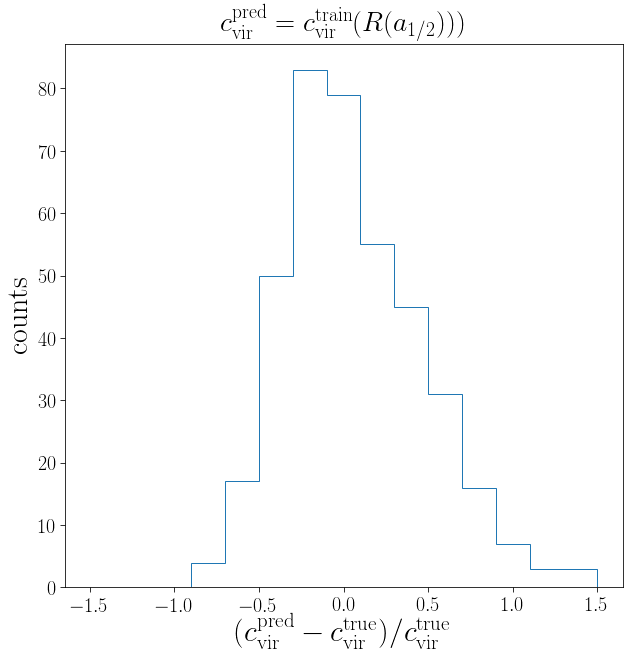

In [75]:
# where do we need to insert each id in sub_pids to keep host_ids ordered.
sorted_idx = np.searchsorted(a_2_train, a_2_test)

#for the ones that are bigger than everything, just default to the upper bound
sorted_idx[sorted_idx >= len(a_2_train)] = len(a_2_train) - 1

#just take the corresponding cvir as pred. 
cvir_pred = cvir_train[sorted_idx]

plt.hist( (cvir_pred - cvir_test) / cvir_test , histtype='step', bins=15, range=(-1.5, 1.5))
plt.xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
plt.ylabel(r"$\rm counts$", size=30)
plt.title(r"$c_{\rm vir}^{\rm pred} = c_{\rm vir}^{\rm train}(R(a_{1/2})))$")

plt.show()

In [76]:
scipy.stats.spearmanr(cvir_test, cvir_pred)

SpearmanrResult(correlation=0.5615894640735838, pvalue=1.2708772140199927e-34)

## assume covariance between a(m_i) bins is 0

In [78]:
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train, ind=True)
assert callable(mu_cond)

In [79]:
log_cvir_pred = mu_cond(lam_test)
print(log_cvir_pred.shape)

(9400,)


Text(0, 0.5, '$\\rm counts$')

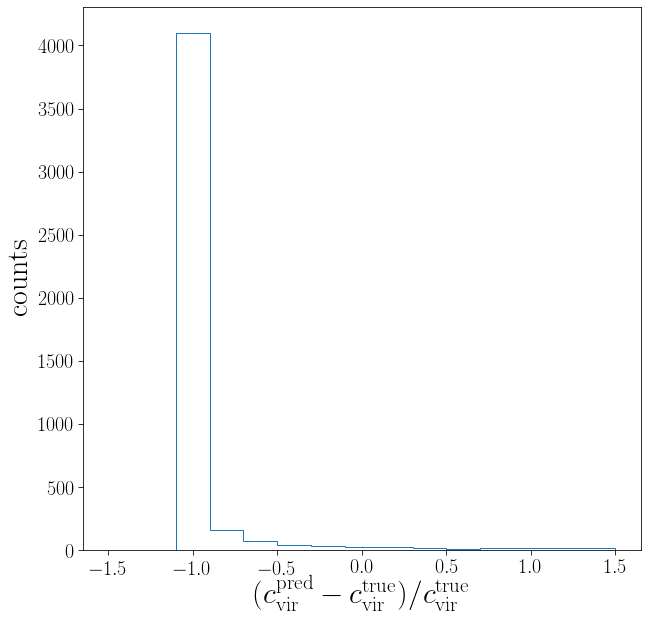

In [80]:
cvir_pred = np.exp(log_cvir_pred)

plt.hist( (cvir_pred - cvir_test) / cvir_test , histtype='step', bins=15, range=(-1.5, 1.5))
plt.xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
plt.ylabel(r"$\rm counts$", size=30)

In [81]:
scipy.stats.spearmanr(cvir_pred, cvir_test)

SpearmanrResult(correlation=0.7404011154683978, pvalue=0.0)

### Check this method agrees with the math. 

In [82]:
lam_train.shape

(9400, 98)

In [85]:
y = (np.log(cvir_train) - np.log(cvir_train).mean()) / np.log(cvir_train).std()
x = (lam_train - lam_train.mean(axis=0).reshape(1, 98)) / lam_train.std(axis=0).reshape(1, 98)


mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(y, x, ind=True)
assert callable(mu_cond)

In [90]:
x_test = (lam_test - lam_test.mean(axis=0).reshape(1, 98)) / lam_test.std(axis=0).reshape(1, 98)
y_pred = mu_cond(x_test)
sigma_pred = sigma_cond
print(y_pred)
print(sigma_pred.item())

[ -18.24854533   -4.96012367 -132.43853876 ...   46.42352553    6.44701081
   -3.44804527]
-37.72175804028138


In [91]:
Sigma.shape

(99, 99)

In [103]:
# theoretical math prediction.
x_test = (lam_test - lam_test.mean(axis=0).reshape(1, 98)) / lam_test.std(axis=0).reshape(1, 98)
mu_theo = Sigma[0, 1:].reshape(1, 98).dot(x_test.T.reshape(98, -1))
sigma_theo = 1 - (Sigma[0, 1:]**2).sum()
print(mu_theo)
print(sigma_theo)

[[ -18.25048687   -4.9606514  -132.45262947 ...   46.42846473
     6.44769673   -3.44841212]]
-37.72598422013396


## Linear Regression

In [11]:
print(cvir_train.shape, cvir_test.shape)

(9400,) (9400,)


In [12]:
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
# requires shape (n_samples, n_features)

x_train = (lam_train - lam_train.mean(axis=0).reshape(1, 98)) / lam_train.std(axis=0).reshape(1, 98)
x_test = (lam_test - lam_test.mean(axis=0).reshape(1, 98)) / lam_test.std(axis=0).reshape(1, 98)
y_train = (np.log(cvir_train) - np.log(cvir_train).mean()) / np.log(cvir_train).std()
y_test = (np.log(cvir_test) - np.log(cvir_test).mean()) / np.log(cvir_test).std()


reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)


Text(0, 0.5, '$\\rm counts$')

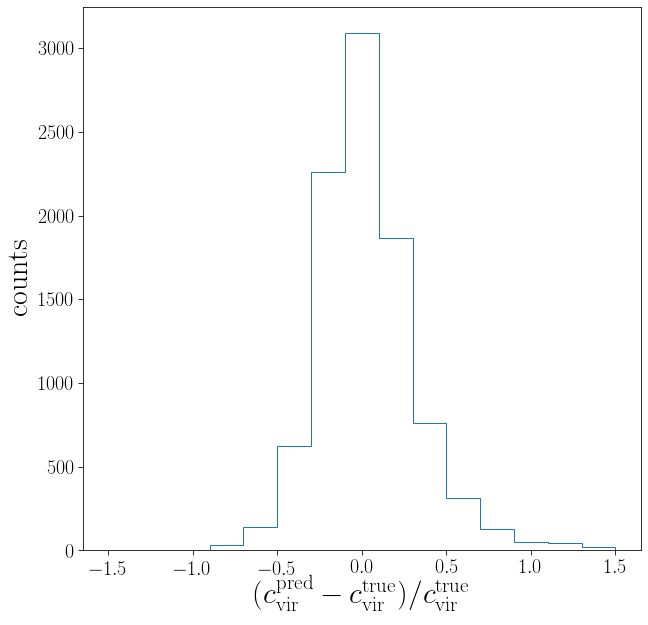

In [13]:
cvir_pred = np.exp((y_pred * np.log(cvir_train).std()) + np.log(cvir_train).mean())

plt.hist( (cvir_pred - cvir_test) / cvir_test , histtype='step', bins=15, range=(-1.5, 1.5))
plt.xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
plt.ylabel(r"$\rm counts$", size=30)

In [14]:
scipy.stats.spearmanr(cvir_pred, cvir_test)

SpearmanrResult(correlation=0.7663429031463556, pvalue=0.0)

# Put all together

In [36]:
cvir.shape

(9999,)

In [46]:
# separate into train/validation set. 
lam =  np.log(am)

# for testing set, pick from haloes that do not have NaNs in their a(m) history. 
# since the training ones it's a lot easier to handle the NaNs consistently and not throw away data points.
assert np.sum(np.isnan(np.log(cvir))) == 0
keep = np.ones(len(lam), dtype=bool)
for i in range(len(lam)):
    keep[i] = ~np.any(np.isnan(lam[i, :]))
test_indices = np.random.choice(np.where(keep)[0], size=3000, replace=False)
train_indices = set(range(cvir.shape[0])) - set(test_indices)
train_indices = list(train_indices)

cvir_test = cvir[test_indices]
cvir_train = cvir[train_indices]

lam_test = lam[test_indices]
lam_train = lam[train_indices]


assert np.sum(np.isnan(lam_test)) == 0
# assert np.sum(np.isnan(lam_train)) == 0
assert lam_test.shape == (3000, 98)
assert lam_train.shape == (6999, 98)

In [47]:
print(cvir_test.shape)
print(lam_test.shape)

(3000,)
(3000, 98)


(3000,)
(3000,)
(3000,)


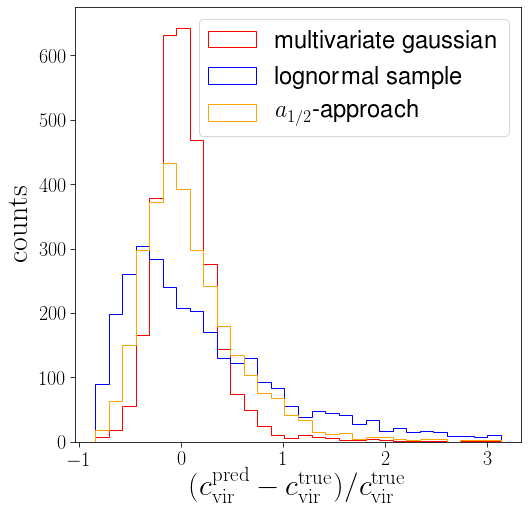

In [52]:
fig, ax = plt.subplots(1,1,figsize=(8,8))


# use gaussian multivariate conditional
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train)
assert callable(mu_cond)
log_cvir_pred = mu_cond(lam_test)
cvir_pred = np.exp(log_cvir_pred)
x = (cvir_pred - cvir_test) / cvir_test

bins = get_bins(x)

print(x.shape)
draw_histogram(ax, x, vline=None, legend_label='multivariate gaussian', color='r', bins=bins, density=False)


# sampling from lognormal with mean/var equal to true distribution.
log_cvir_pred = np.random.normal(np.mean(np.log(cvir_train)), np.std(np.log(cvir_train)), 3000)
cvir_pred = np.exp(log_cvir_pred)
x = (cvir_pred - cvir_test) / cvir_test
print(x.shape)
draw_histogram(ax, x, vline=None, legend_label='lognormal sample', color='b', bins=bins, density=False)


# Rank of a_1/2 approach.
idx = np.where((0.498 < mass_bins) & (mass_bins < 0.51) )[0].item()
a_2 = am[:, idx]


sort_train = np.argsort(a_2[train_indices])
sort_test = np.argsort(a_2[test_indices])

a_2_train = a_2[train_indices][sort_train]
a_2_test = a_2[test_indices][sort_test]

_cvir_train = cvir[train_indices][sort_train]
_cvir_test = cvir[test_indices][sort_test]

# where do we need to insert each id in sub_pids to keep host_ids ordered.
sorted_idx = np.searchsorted(a_2_train, a_2_test)

#for the ones that are bigger than everything, just default to the upper bound
sorted_idx[sorted_idx >= len(a_2_train)] = len(a_2_train) - 1

#just take the corresponding cvir as pred. 
_cvir_pred = _cvir_train[sorted_idx]
x = (_cvir_pred - _cvir_test) / _cvir_test
draw_histogram(ax, x, vline=None, legend_label=r'$a_{1/2}$-approach', color='orange', bins=bins, density=False)
print(x.shape)


ax.set_xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
ax.set_ylabel(r"\rm counts", size=30)

ax.legend()
plt.show()